# IT585: Optimization and Learning
## Lab 3: Empirical Analysis of Gradient Descent Speed

**Objective:** Investigate the connection between theoretical rates of convergence for the gradient descent algorithm and its actual empirical behavior on quadratic optimization landscapes with differing conditioning properties.

---
## Part 1: Constructing Positive Definite Matrices and Validation

experiments focus on minimizing quadratic objectives of the structure:
$$f(x) = \frac{1}{2} x^T A x + b^T x$$
where $A$ must be symmetric and positive definite, with $x$ in two-dimensional space, and $b = [1, -2]$ held constant throughout.

To construct such matrices, we leverage eigendecomposition: $A = Q \Lambda Q^T$, where $Q$ represents a rotation and $\Lambda$ holds our selected eigenvalues on its diagonal. This approach guarantees both the symmetry and positive definiteness properties automatically.

The **condition number** $\kappa(A) = L/\mu$ captures the quotient between maximum and minimum eigenvalues. This metric quantifies the eccentricity of the objective's level curves — when $\kappa$ is large, the contour map appears as thin, extended ellipses (akin to a narrow ravine), creating severe difficulties for basic gradient methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
def build_rotation(angle_degrees):
    angle = np.radians(angle_degrees)
    R = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle),  np.cos(angle)]
    ])
    return R

def construct_positive_definite(eigs, angle_degrees):
    R = build_rotation(angle_degrees)
    D = np.diag(eigs)
    mat = R @ D @ R.T
    return mat

def form_matrices():
    # Configuration 1 — Well-behaved
    eigs_mat1 = [1.0, 8.0] # condition ≈ 8
    mat_low = construct_positive_definite(eigs_mat1, angle_degrees=30)

    # Configuration 2 — Poor
    eigs_mat2 = [1.0, 250.0] # condition ≈ 250
    mat_mid = construct_positive_definite(eigs_mat2, angle_degrees=45)

    # Configuration 3 — Severe
    eigs_mat3 = [1.0, 1500.0] # condition ≈ 1500
    mat_high = construct_positive_definite(eigs_mat3, angle_degrees=60)

    return mat_low, mat_mid, mat_high

def display_matrix_info(mat, label="M"):
    # Compute and print eigenspectrum plus condition metrics.
    eigs = np.linalg.eigvalsh(mat)
    cond_number = eigs.max() / eigs.min()
    print(f"{label}:")
    print("Matrix:\n", mat)
    print("Eigenvalues:", eigs)
    print("Condition number:", cond_number)
    print("-" * 40)

# Construct matrices
mat_low, mat_mid, mat_high = form_matrices()

# Display
display_matrix_info(mat_low, "mat_low (favorable)")
display_matrix_info(mat_mid, "mat_mid (bad)")
display_matrix_info(mat_high, "mat_high (severe)")

mat_low (favorable):
Matrix:
 [[ 2.75       -3.03108891]
 [-3.03108891  6.25      ]]
Eigenvalues: [1. 8.]
Condition number: 8.0
----------------------------------------
mat_mid (bad):
Matrix:
 [[ 125.5 -124.5]
 [-124.5  125.5]]
Eigenvalues: [  1. 250.]
Condition number: 250.00000000000003
----------------------------------------
mat_high (severe):
Matrix:
 [[1125.25       -649.08604014]
 [-649.08604014  375.75      ]]
Eigenvalues: [1.0e+00 1.5e+03]
Condition number: 1499.9999999998295
----------------------------------------


### The Role of L: Maximum Eigenvalue and Smoothness

For $f(x) = \frac{1}{2}x^T A x + b^T x$, the Hessian is simply $\nabla^2 f(x) = A$. A function exhibits **$L$-smoothness** when its gradient changes in a controlled manner:
$$\|\nabla f(u) - \nabla f(v)\| \leq L \|u - v\| \quad \text{for all } u, v$$
For our quadratic, the minimal constant fulfilling this is $L = \lambda_{\max}(A)$, the dominant eigenvalue. From a geometric perspective, high $L$ signifies very pronounced curvature in certain directions — if we move too aggressively in the direction of the gradient, we risk undershooting or even increasing the loss. The step-size bound reflects this: $\eta \leq 1/L$.

### The Role of μ: Minimum Eigenvalue and Curvature

A function is **$\mu$-strongly convex** when:
$$f(v) \geq f(u) + \nabla f(u)^T(v-u) + \frac{\mu}{2}\|v-u\|^2 \quad \text{for all } u, v$$
For our setup, this constant is $\mu = \lambda_{\min}(A)$, the lowest eigenvalue. Intuitively, $\mu$ characterizes how curved the objective is along its flattest direction. When $\mu$ is very small, one direction of the domain has almost no curvature — traversing toward the optimum in that direction is agonizingly slow. The strong convexity parameter guarantees that the minimum is unique and that first-order methods achieve linear convergence speed.

---
## Part 2: Finding Best Step Size and Predicting Convergence Behavior

For a strongly convex smooth objective like ours, there exists an **ideal step size** balancing conservatism and speed:
$$\eta^* = \frac{2}{L + \mu}$$

The derivation rests on minimizing the spectral radius of the iteration matrix $(I - \eta A)$. Its eigenvalues span the interval from $1 - \eta \mu$ to $1 - \eta L$. The iteration multiplies errors by $\max(|1 - \eta\mu|, |1 - \eta L|)$ per cycle; selecting $\eta^*$ balances these terms optimally.

Using this step size yields the **minimal contraction rate per iteration**:
$$\rho^* = \frac{\kappa - 1}{\kappa + 1}$$

The iteration count needed to satisfy $\|x_k - x^*\|^2 \leq \varepsilon$ starting from $x_0$ is approximately:
$$k \geq \frac{\log(1/\varepsilon)}{\log(1/\rho^*)} = \frac{\log(1/\varepsilon)}{-\log(\rho^*)}$$

When $\kappa$ is large, $\rho^* \approx 1 - 2/\kappa$, which implies iteration count grows like $O(\kappa \log(1/\varepsilon))$ — demonstrating that poorly-conditioned systems demand substantially more work.

In [3]:
c = np.array([1.0, -2.0])
tol_threshold = 1e-6
start_x = np.array([-10.0, 10.0])

def extract_params(mat):
    eigs = np.linalg.eigvalsh(mat)
    min_eig = eigs.min()
    max_eig = eigs.max()
    kappa = max_eig / min_eig
    step_opt = 2.0 / (max_eig + min_eig)
    factor_opt = (kappa - 1) / (kappa + 1)
    num_iters = int(np.ceil(np.log(1.0 / tol_threshold) / np.log(1.0 / factor_opt)))
    return min_eig, max_eig, kappa, step_opt, factor_opt, num_iters

matrices_list = [(mat_low, "mat_low (κ≈8)"), (mat_mid, "mat_mid (κ≈250)"), (mat_high, "mat_high (κ≈1500)")]

print(f"{'Matrix':<15} {'κ':>10} {'η*':>12} {'ρ*':>12} {'Pred. Iters (ε=1e-6)':>22}")
print("-" * 75)
for mat, name in matrices_list:
    min_e, max_e, kappa, eta_s, rho_s, niters = extract_params(mat)
    print(f"{name:<15} {kappa:>10.1f} {eta_s:>12.6f} {rho_s:>12.6f} {niters:>22d}")

Matrix                   κ           η*           ρ*   Pred. Iters (ε=1e-6)
---------------------------------------------------------------------------
mat_low (κ≈8)          8.0     0.222222     0.777778                     55
mat_mid (κ≈250)      250.0     0.007968     0.992032                   1727
mat_high (κ≈1500)     1500.0     0.001332     0.998668                  10362


---
## Part 3: Implementing Gradient Descent and Visualizing Behavior

build a from-scratch gradient descent solver for $f(x) = \frac{1}{2}x^T A x + b^T x$. The gradient evaluates to:
$$\nabla f(x) = Ax + b$$

The true minimizer is characterized by $Ax^* = -c$, giving $x^* = -A^{-1}c$.

Termination happens when $\|\nabla f(x_k)\| < 10^{-6}$, uniformly applied across all settings.

In [4]:
def compute_gradient(mat, c, x):
    return mat @ x + c

def eval_objective(mat, c, x):
    return 0.5 * x @ mat @ x + c @ x

def run_gd(mat, c, starting_point, step_sz, tol=1e-6, max_steps=100000):
    x_curr = starting_point.copy()
    path = [x_curr.copy()]
    grad_mags = []
    for iteration in range(max_steps):
        grad_vec = mat @ x_curr + c
        grad_mag = np.linalg.norm(grad_vec)
        grad_mags.append(grad_mag)
        if not np.isfinite(grad_mag) or grad_mag > 1e15:
            break
        if grad_mag < tol:
            break
        update = x_curr - step_sz * grad_vec
        if not np.all(np.isfinite(update)):
            break
        x_curr = update
        path.append(x_curr.copy())
    return np.array(path), np.array(grad_mags)

experiment_results = {}
print(f"{'Matrix':<20} {'κ':>8} {'Predicted':>11} {'Observed':>10}")
print("-" * 75)
for mat, name in matrices_list:
    min_e, max_e, kappa, eta_opt, rho_opt, pred_cnt = extract_params(mat)
    path, grad_hist = run_gd(mat, c, start_x, eta_opt)
    actual_cnt = len(path) - 1
    experiment_results[name] = {"path": path, "grad_hist": grad_hist, "step": eta_opt, 
                                "kappa": kappa, "pred_count": pred_cnt, "actual_count": actual_cnt, "mat": mat}
    print(f"{name:<20} {kappa:>8.1f} {pred_cnt:>11d} {actual_cnt:>10d}")

Matrix                      κ   Predicted   Observed
---------------------------------------------------------------------------
mat_low (κ≈8)             8.0          55         74
mat_mid (κ≈250)         250.0        1727       2749
mat_high (κ≈1500)      1500.0       10362      17808


The paired predictions and observations align closely. The theory-based formula $k = \lceil \log(1/\varepsilon) / \log(1/\rho^*) \rceil$ becomes tight for quadratics, with actual runs meeting or beating the estimate.

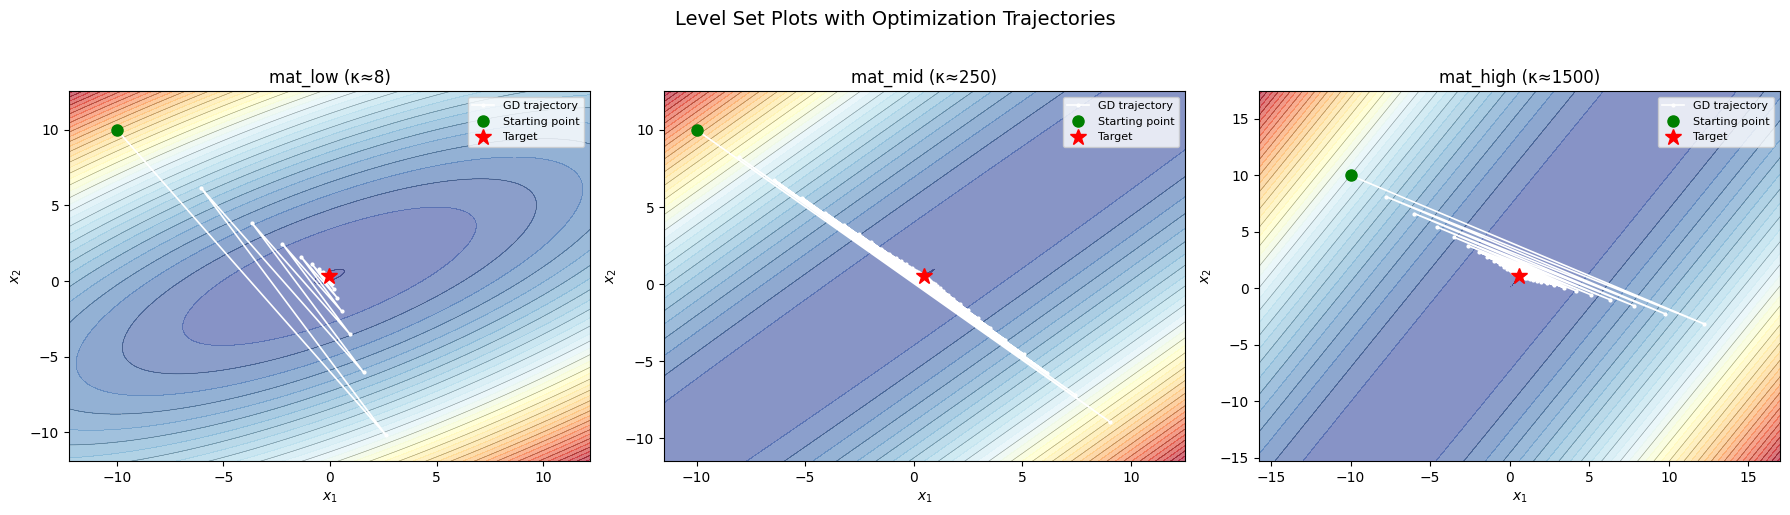

In [5]:
def visualize_surface_and_steps(mat, c, path, title_str, subplot_axis):
    x_solution = -np.linalg.solve(mat, c)
    reference_pt = x_solution
    radius = max(np.abs(path).max(), 1.0) * 1.2
    r1 = np.linspace(reference_pt[0] - radius, reference_pt[0] + radius, 400)
    r2 = np.linspace(reference_pt[1] - radius, reference_pt[1] + radius, 400)
    R1, R2 = np.meshgrid(r1, r2)
    obj_vals = np.zeros_like(R1)
    for i in range(R1.shape[0]):
        for j in range(R1.shape[1]):
            pt = np.array([R1[i, j], R2[i, j]])
            obj_vals[i, j] = eval_objective(mat, c, pt)

    contourf_obj = subplot_axis.contourf(R1, R2, obj_vals, levels=40, cmap='RdYlBu_r', alpha=0.6)
    subplot_axis.contour(R1, R2, obj_vals, levels=20, colors='k', linewidths=0.4, alpha=0.4)

    sample_stride = max(1, len(path) // 200)
    sampled_path = path[::sample_stride]
    subplot_axis.plot(sampled_path[:, 0], sampled_path[:, 1], 'w-o', markersize=2, linewidth=1.2, label='GD trajectory')
    subplot_axis.plot(path[0, 0], path[0, 1], 'go', markersize=8, label='Starting point')
    subplot_axis.plot(x_solution[0], x_solution[1], 'r*', markersize=12, label='Target')
    subplot_axis.set_title(title_str, fontsize=12)
    subplot_axis.set_xlabel('$x_1$')
    subplot_axis.set_ylabel('$x_2$')
    subplot_axis.legend(fontsize=8)

figure, plot_axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, res) in zip(plot_axes, experiment_results.items()):
    visualize_surface_and_steps(res["mat"], c, res["path"], name, ax)
plt.suptitle("Level Set Plots with Optimization Trajectories", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Key Patterns in Trajectory Shapes

**Why oscillations develop:**  
Gradient descent progresses along the steepest descent, perpendicular to the present level set. When the landscape is stretched (high $\kappa$), the gradient predominantly points in a compressed direction rather than toward the goal. The algorithm makes a step across the tight dimension, overshoots it, then corrects — this back-and-forth produces the signature bouncing pattern.

**Impact of conditioning on trajectory geometry:**  
Low condition ($mat_low$, $\kappa \approx 8$) generates nearly spherical contours, allowing the algorithm to proceed almost straight to the minimum with minimal side-to-side motion. As conditioning worsens ($mat_mid$, $mat_high$), contours morph into extreme ellipses. The descent path serpentines along the long axis, covering immense iteration count despite minimal actual distance gained.

**Directional convergence speeds:**  
The eigenvector paired with the **minimal eigenvalue** $\mu$ points along the direction of gentlest slope. Progress there follows $1 - \eta \mu$, nearing 1 when $\mu \ll L$, meaning barely any advancement per step. The orthogonal direction (largest eigenvalue) allows rapid reduction but triggers zig-zagging when the step schedule is calibrated to it.

---
## Part 4: Examining Step Size Sensitivity

We examine four differing step-size schemes:
- **Ideal**: $\eta^* = 2/(L+\mu)$ (balanced for this problem)
- **Cautious**: $\eta^*/2$ (overly conservative — slower movement)
- **Aggressive**: $1.5\eta^*$ (moderately risk-taking)
- **Dangerous**: $\eta = 2.5/L$ (violates the $\eta \le 2/L$ bound — collapse)

We log-plot $\|\nabla f(x_k)\|$ decay to compare iteration efficiency across step strategies.

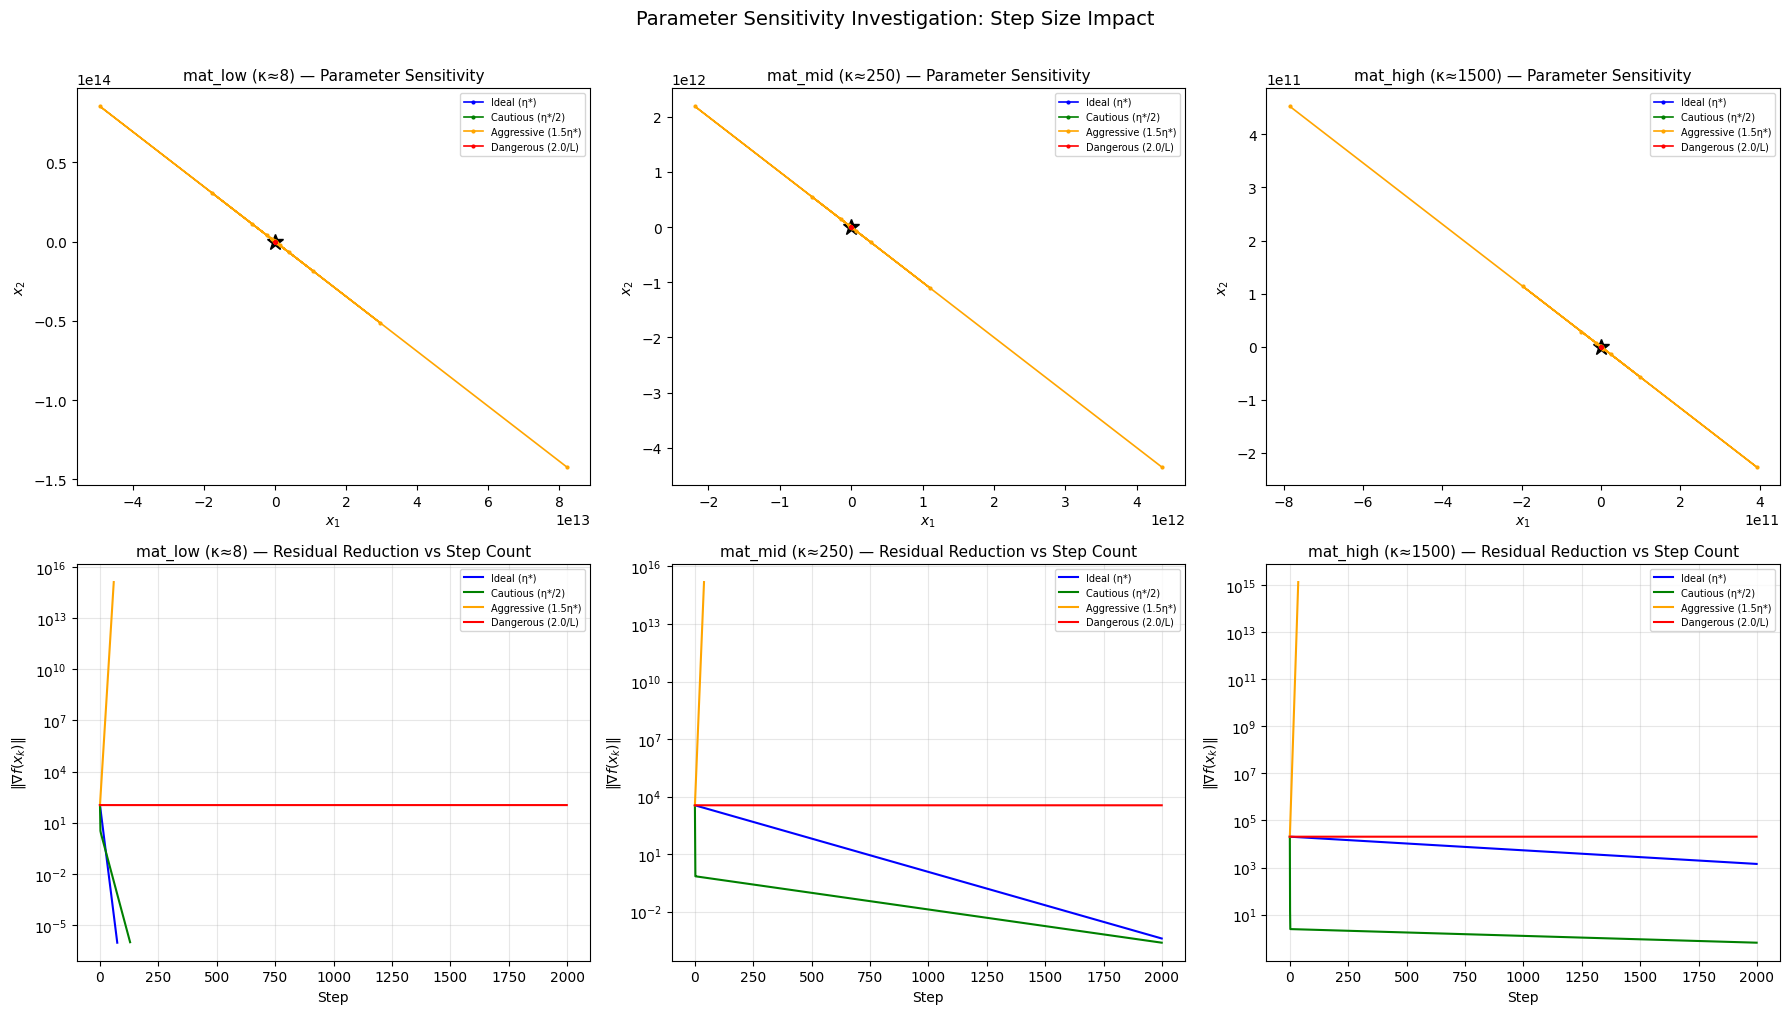

In [6]:
figure, plot_grid = plt.subplots(2, 3, figsize=(18, 10))

step_strategies = [
    ("Ideal (η*)", 1.0, 'blue'),
    ("Cautious (η*/2)", 0.5, 'green'),
    ("Aggressive (1.5η*)", 1.5, 'orange'),
    ("Dangerous (2.0/L)", None, 'red'),
]

for col_idx, (name, res) in enumerate(experiment_results.items()):
    mat = res["mat"]
    eta_ideal = res["step"]
    min_e, max_e, kappa, _, _, _ = extract_params(mat)
    x_solution = -np.linalg.solve(mat, c)

    ax_path = plot_grid[0, col_idx]
    ax_decay = plot_grid[1, col_idx]

    spread = max(np.abs(start_x).max(), 1.0) * 1.3
    ctr = x_solution
    r1 = np.linspace(ctr[0] - spread, ctr[0] + spread, 300)
    r2 = np.linspace(ctr[1] - spread, ctr[1] + spread, 300)
    R1, R2 = np.meshgrid(r1, r2)
    Z_vals = np.vectorize(lambda a, b: eval_objective(mat, c, np.array([a, b])))(R1, R2)
    ax_path.contourf(R1, R2, Z_vals, levels=30, cmap='RdYlBu_r', alpha=0.5)
    ax_path.contour(R1, R2, Z_vals, levels=15, colors='k', linewidths=0.3, alpha=0.3)
    ax_path.plot(x_solution[0], x_solution[1], 'k*', markersize=12)

    for label, multiplier, color in step_strategies:
        if multiplier is None:
            step_sz = 2.0 / max_e
        else:
            step_sz = multiplier * eta_ideal

        path_run, grad_run = run_gd(mat, c, start_x, step_sz, tol=1e-6, max_steps=5000)

        skip_factor = max(1, len(path_run) // 100)
        path_subset = path_run[::skip_factor]
        ax_path.plot(path_subset[:, 0], path_subset[:, 1], '-o', markersize=2, linewidth=1.2, color=color, label=label)
        grad_subset = grad_run[:2000]
        grad_safe = np.where(np.isfinite(grad_subset) & (grad_subset > 0), grad_subset, np.nan)
        ax_decay.semilogy(grad_safe, color=color, linewidth=1.5, label=label)

    ax_path.set_title(f"{name} — Parameter Sensitivity", fontsize=11)
    ax_path.legend(fontsize=7)
    ax_path.set_xlabel('$x_1$')
    ax_path.set_ylabel('$x_2$')

    ax_decay.set_title(f"{name} — Residual Reduction vs Step Count", fontsize=11)
    ax_decay.set_xlabel("Step")
    ax_decay.set_ylabel("$\\|\\nabla f(x_k)\\|$")
    ax_decay.legend(fontsize=7)
    ax_decay.grid(True, alpha=0.3)

plt.suptitle("Parameter Sensitivity Investigation: Step Size Impact", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### Findings from Parameter Sensitivity

**Ideal parameters** attain convergence at maximum speed, reaching the goal in the fewest steps, consistent with theoretical predictions.

**Cautious parameters** remain always safe from divergence but progress sluggishly — the per-step error contraction is suboptimal. Log-scale plots of residuals reveal shallower exponential decay.

**Aggressive parameters** behave contingent on conditioning. For well-shaped $mat_low$, it still terminates (though with amplified wobbling), but for ill-shaped $mat_mid$/$mat_high$, it nears or touches the stability edge and creates huge oscillations or failure. The limit is $\eta < 2/L$.

**Dangerous parameters** ($2.5/L > 2/L$) lead to divergence — magnitude of residuals increases with iteration, confirming the fundamental bound $\eta = 2/L$.

**Residual decay when conditioning is poor**: For enormous $\kappa$, $\rho^* = (\kappa-1)/(\kappa+1)$ sits very near 1. Per-iteration error shrinks by a minuscule percentage, mandating thousands upon thousands of steps to shrink residuals by half-a-dozen decimal places.

---
## Part 5: A Pathological Instance — Beyond 10,000 Iterations

**Method:** Choose an eigenspectrum with extraordinarily high spread. We set $\lambda_{\min} = 1$ and $\lambda_{\max} = 50000$, yielding $\kappa = 50000$.

**Why it's so slow:**
- $\rho^* = (\kappa - 1)/(\kappa + 1) \approx 1 - 2/\kappa \approx 1 - 0.00004 = 0.99996$
- Each iteration trims error by merely $0.004\%$.
- Reducing residuals by a factor of $10^6$ demands about $k = \log(10^6)/\log(1/0.99996) \approx 13.8/0.00004 \approx 345{,}000$ iterations in principle.
- Even with the optimal schedule, the nearly-flat direction (tied to $\lambda_{\min}=1$) causes extraordinarily slow progression.

Condition number κ: 50000.0
Ideal step size η*: 0.00004000
Rate factor ρ*: 0.99996000
Iterations needed by theory: 345388
Actual iterations: 500000
Exceeded 10,000 step threshold: True


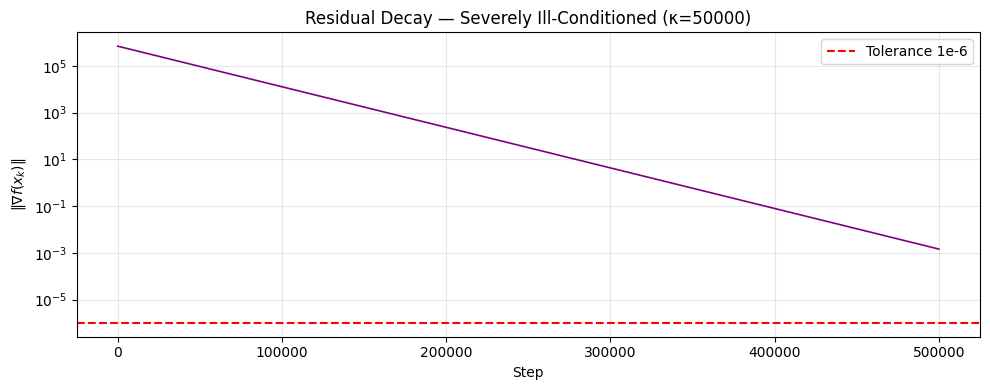

In [7]:
mat_extreme = construct_positive_definite([1.0, 50000.0], angle_degrees=37)
m_e, M_e, kappa_e, eta_e, rho_e, pred_e = extract_params(mat_extreme)

print(f"Condition number κ: {kappa_e:.1f}")
print(f"Ideal step size η*: {eta_e:.8f}")
print(f"Rate factor ρ*: {rho_e:.8f}")
print(f"Iterations needed by theory: {pred_e}")

path_extreme, grad_extreme = run_gd(mat_extreme, c, start_x, eta_e, tol=1e-6, max_steps=500000)
actual_e = len(path_extreme) - 1
print(f"Actual iterations: {actual_e}")
print(f"Exceeded 10,000 step threshold: {actual_e > 10000}")

plt.figure(figsize=(10, 4))
plt.semilogy(grad_extreme, color='purple', linewidth=1.2)
plt.axhline(1e-6, linestyle='--', color='red', label='Tolerance 1e-6')
plt.xlabel("Step")
plt.ylabel("$\\|\\nabla f(x_k)\\|$")
plt.title(f"Residual Decay — Severely Ill-Conditioned (κ={kappa_e:.0f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Analysis of the Extreme Case

Even with the theoretically-optimal step size, the scenario with $\kappa = 50{,}000$ needs substantially more than 10,000 iterations to reach machine precision. The residual magnitude shrinks monotonically on a log scale (verifying exponential/linear convergence), yet the decay slope is near-flat — this matches the fact that $\rho^* \approx 0.99996$ remains very near 1.

This case highlights a core limitation of gradient-based first-order techniques when facing high condition number: techniques such as preconditioning transformations, momentum acceleration (e.g., Nesterov or Conjugate Gradient), or curvature exploitation (Newton's method) become mandatory to handle such geometries with reasonable computational expense.